In [ ]:
!wget -O "virtualgl_2.6.4_amd64.deb" "https://sourceforge.net/projects/virtualgl/files/2.6.4/virtualgl_2.6.4_amd64.deb/download"
!dpkg -i virtualgl_2.6.4_amd64.deb
!printf '#!/bin/bash\nVGL_DEFAULTFBCONFIG=GLX_ALPHA_SIZE,8 DISPLAY=:0 vglrun +v /usr/bin/chromium-browser --disable-gpu-sandbox "$@"' > chromium-vgl.sh && chmod a+x ./chromium-vgl.sh
!pip install git+https://github.com/demotomohiro/remocolab.git
import remocolab
remocolab._setup_nvidia_gl()

!pip install gym-derk

# This is a hack to get pyppeteer working, suggested in: https://github.com/googlecolab/colabtools/issues/1553
from google.colab import output
with output.temporary():
  !pip install pyppeteer tornado==4.5.3 
  !apt update
  !apt install chromium-chromedriver

import os
import signal

# Kill the process to restart with the older tornado version.
os.kill(os.getpid(), signal.SIGTERM)

--2022-01-03 16:35:22--  https://sourceforge.net/projects/virtualgl/files/2.6.4/virtualgl_2.6.4_amd64.deb/download
Resolving sourceforge.net (sourceforge.net)... 204.68.111.105
Connecting to sourceforge.net (sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/virtualgl/2.6.4/virtualgl_2.6.4_amd64.deb?ts=gAAAAABh0yXLbo6_JtkkUtRcfvDREXAUmLs3n3j33tL72yzr5E04klDNwtID5coB0ZZBwbF6A4kanGuiXCwJkcgGJg4-QXjmwQ%3D%3D&use_mirror=udomain&r= [following]
--2022-01-03 16:35:23--  https://downloads.sourceforge.net/project/virtualgl/2.6.4/virtualgl_2.6.4_amd64.deb?ts=gAAAAABh0yXLbo6_JtkkUtRcfvDREXAUmLs3n3j33tL72yzr5E04klDNwtID5coB0ZZBwbF6A4kanGuiXCwJkcgGJg4-QXjmwQ%3D%3D&use_mirror=udomain&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting resp

     |████████████████████████████████| 484 kB 4.3 MB/s 
  Created wheel for tornado: filename=tornado-4.5.3-cp37-cp37m-linux_x86_64.whl size=434053 sha256=f8df797d28e2618c53f311f6994664054b64e01174dcc510592bac830409be0e
  Stored in directory: /root/.cache/pip/wheels/a2/45/43/36ec7a893e16c1212a6b1505ded0a2d73cf8e863a0227c8e04
Successfully built tornado
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 4.5.3 which is incompatible.
bokeh 2.3.3 requires tornado>=5.1, but you have tornado 4.5.3 which is incompatible.


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [833 kB]
Get:13 http

In [ ]:
import os
os.environ['DERK_CHROME_EXECUTABLE'] = './chromium-vgl.sh'
import nest_asyncio
nest_asyncio.apply()

from gym_derk.envs import DerkEnv
from gym_derk import ObservationKeys
from gym_derk import ActionKeys

import torch
import numpy as np
import torch.nn as nn
import math
import torch.optim as optim
import asyncio
import json
from torch.nn import functional as F

In [ ]:
class Memory:
    def __init__(self, max_length=30000):
        self.max_length = max_length
        self.state_buffer = np.zeros((self.max_length, 64*3)) # 64 = state_space * 3 players per team
        self.action_buffer = np.zeros((self.max_length, 5*3)) # 13 = action_space_list * 3 players per team
        self.reward_buffer = np.zeros((self.max_length))
        self.nextstate_buffer = np.zeros((self.max_length, 64*3))
        self.counter = 0
        
    def __len__(self):
        return self.counter
    
    def push(self, obs, action, reward, obs_):
        self.counter = (self.counter+1) % self.max_length
        self.state_buffer[self.counter] = obs
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.nextstate_buffer[self.counter] = obs_
        
    def lookup_history(self, V, obs, action, buffer, gamma=0.9):
        idx_obs = np.where((self.state_buffer==obs).all(1))[0]
        idx_action = np.where((self.action_buffer==action).all(1))[0]
        
        idx = np.intersect1d(idx_obs, idx_action)
        if idx.shape[0]==0:
            return torch.tensor([0.], requires_grad=True)
        
        
        s = buffer.state_buffer[idx]
        state = np.concatenate([self.state_buffer[idx], s], axis=1)
        
        payoff = torch.FloatTensor(self.reward_buffer[idx])
        v_out = V(torch.FloatTensor(state))
        
        return (torch.sum(payoff)+gamma*torch.sum(v_out)) / idx.shape[0]
        
    def clear(self):
        self.counter = 0;
        self.state_buffer = np.zeros((self.max_length, 64*3))
        self.action_buffer = np.zeros((self.max_length, 5*3))
        self.reward_buffer = np.zeros((self.max_length))
        self.nextstate_buffer = np.zeros((self.max_length, 64*3))
        

In [ ]:
class Actor(nn.Module): 
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        self.policynetwork = nn.Sequential(
            nn.Linear(self.state_size*3, 128),
            nn.Linear(128, 256), 
            nn.Linear(256, 13*3))

    def forward(self, state):
        outputs = self.policynetwork(torch.FloatTensor(state))
        outputs = outputs.detach().numpy()
        action=[]
        for i in range(3):
            start=13*i
            casts = outputs[start+3:start+6]
            cast_i = np.argmax(casts)
            focuses = outputs[start+6:start+13]
            focus_i = np.argmax(focuses)
            move_x = max(min(math.tanh(outputs[0+start])+ np.random.uniform(-0.1,0.1),1),-1)
            rotate = max(min(math.tanh(outputs[0+start])+ np.random.uniform(-0.1,0.1),1),-1)
            action.append((
              move_x, # MoveX
              rotate, # Rotate
              max(min(outputs[2+start] + np.random.uniform(-0.1,0.1), 1), 0), # ChaseFocus
              (cast_i + 1) if casts[cast_i] > 0 else 0, # CastSlot
              (focus_i + 1) if focuses[focus_i] > 0 else 0, # Focus
            ))
        return action

In [ ]:
def calculate_rho(state_a, state_b, V, a, b, gamma=0.9):
    # only check one side of the state
    idx_obsA = np.where((a.state_buffer==state_a).all(1))[0]
    idx_obsB = np.where((b.state_buffer==state_b).all(1))[0]
    
    idx = np.intersect1d(idx_obsA, idx_obsB)
    
    if idx.shape[0]==0:
        return torch.tensor([0.], requires_grad=True)

    
    reward_a = torch.FloatTensor(a.reward_buffer[idx_obsA])
    nextstate_a = a.nextstate_buffer[idx]
    nextstate_b = b.nextstate_buffer[idx]
    
    nextstate = np.concatenate([nextstate_a, nextstate_b], axis=1)

    value = V(torch.FloatTensor(nextstate))
    
    return (torch.sum(reward_a)+gamma*torch.sum(value))/idx_obsA.shape[0]

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.policynetwork = nn.Sequential(
            nn.Linear(self.state_size*6, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 1))

    def forward(self, state):
        output = self.policynetwork(state)
        return output

In [ ]:
env = DerkEnv(
    home_team = [{ 'primaryColor': '#009999', 'slots':['Pistol', None, None]}],
    away_team = [{ 'primaryColor': '#ff3333', 'slots':['Pistol', None, None]}],
    reward_function={
        'damageEnemyStatue': 1,
        'damageEnemyUnit': 1,
        'killEnemyStatue': 10,
        'killEnemyUnit': 5,
        'friendlyFire': -1,
        'teamSpirit': 2,
        'fallDamageTaken': -2
    },
    turbo_mode = True
)

In [ ]:
trajectories = 100
decimal_places = 2
gamma = 0.99
epsilon = 0.2
eta = 1e-4
buffer_size = 2000
logs = 10

In [ ]:
asyncio.get_event_loop().run_until_complete(env.app.page.screenshot(path='test.png'))
from google.colab import drive
drive.mount('/content/drive')
import os
# os.chdir('/content/drive/MyDrive/1class 109下課程/人工智慧概論/hw_4') 
os.chdir('/content/drive/MyDrive/Colab Notebooks') 
os.listdir() #確認目錄內容

actor_a = torch.load("./model/actor_A_4_0.99.pth")#ctor(len(ObservationKeys),len(ActionKeys))
actor_b = torch.load("./model/actor_B_4_0.99.pth")#Actor(len(ObservationKeys),len(ActionKeys))
v = torch.load("./model/ValueNet_4_0.99.pth")#Critic(len(ObservationKeys),len(ActionKeys))


# initialize memory buffer for lookup
buffer_a = Memory(max_length=buffer_size)
buffer_b = Memory(max_length=buffer_size)

# list to record total reward
# with open('a_4_0.99.txt', newline='') as jsonfile:
#     memA = json.load(jsonfile)
# with open('b_4_0.99.txt', newline='') as jsonfile:
#     memB = json.load(jsonfile)

print("already trained {} times".format(len(memA)))
memA = []
memB = []

# initialize loss function for V-network
MSE = nn.MSELoss()

# initialize optimizers
optimizer_actor_a = optim.Adam(actor_a.parameters())
optimizer_actor_b = optim.Adam(actor_b.parameters())
optimizer_v = optim.Adam(v.parameters())

for t in range(trajectories):
    observation_n = env.reset()
    total_reward_A = 0
    total_reward_B = 0
    print("trajectory: {}".format(t))
    step = 1
    reward = []

    #buffer for this round
    temp_buffer_a = Memory()
    temp_buffer_b = Memory()

    if len(memA)>=3000:
      print("finish training")
      break
    while True:
        
        state = observation_n.reshape(64*6)
        
        state_a = observation_n[0:3].reshape(64*3)
        state_b = observation_n[3:6].reshape(64*3)

        state = np.around(state, decimal_places)
        state_a = np.around(state_a, decimal_places)
        state_b = np.around(state_b, decimal_places)
        
        # dim = 13, save this as action
        if np.random.uniform()>epsilon:        
            action_a = actor_a(state_a)
            action_b = actor_b(state_b)
        else:
            one_two = np.random.uniform(-1,1,(3, 2))
            three = np.random.uniform(size=(3, 1))
            four = np.random.randint(4, size=(3, 1))
            five = np.random.randint(8, size =(3, 1))
            action_a = np.concatenate([one_two, three, four, five], axis=1)
            
            one_two = np.random.uniform(-1,1,(3, 2))
            three = np.random.uniform(size=(3, 1))
            four = np.random.randint(4, size=(3, 1))
            five = np.random.randint(8, size =(3, 1))
            action_b = np.concatenate([one_two, three, four, five], axis=1)
            
        action_a = np.around(action_a, decimal_places)
        action_b = np.around(action_b, decimal_places)   
        _action_a = np.asarray(action_a).reshape(15,)
        _action_b = np.asarray(action_b).reshape(15,)

        action_n = [action_a[0], action_a[1], action_a[2], action_b[0], action_b[1], action_b[2]]
        new_observation_n, reward_n, done_n, info = env.step(action_n)
        new_obs_a, new_obs_b = new_observation_n[:3].reshape(64*3), new_observation_n[3:].reshape(64*3)

        reward_a = reward_n[0] + reward_n[1] + reward_n[2]
        reward_b = reward_n[3] + reward_n[4] + reward_n[5]
        
        
        # to zero-sum game
        ra = reward_a
        rb = reward_b
        reward_a = ra - rb
        reward_b = rb - ra
        reward.append(reward_a)
        
        total_reward_A += reward_a
        total_reward_B += reward_b
        
        buffer_a.push(state_a, _action_a, reward_a, new_obs_a)
        buffer_b.push(state_b, _action_b, reward_b, new_obs_b)
        temp_buffer_a.push(state_a, _action_a, reward_a, new_obs_a)
        temp_buffer_b.push(state_b, _action_b, reward_b, new_obs_b)
        

        observation_n=new_observation_n

        if t%logs==0:
            torch.save(actor_a, "./model/actor_A_4_0.99.pth")
            torch.save(actor_b, "./model/actor_B_4_0.99.pth")
            torch.save(v, "./model/ValueNet_4_0.99.pth")
            
        if all(done_n):

            print(total_reward_A)
            memA.append(total_reward_A)
            
            
            memB.append(total_reward_B)
            print("total reward A:{}, total reward B:{}".format(total_reward_A, total_reward_B))
            print("Episode finished\n")
            with open('a_4_0.99.txt', 'w+') as outfile:
              json.dump(memA, outfile)
            with open('b_4_0.99.txt', 'w+') as outfile2:
              json.dump(memB, outfile2)
            #update
            acumulated_reward = 0
            for i in range(len(reward)-1,-1,-1):
                acumulated_reward = acumulated_reward*gamma + reward[i]
                state_a = temp_buffer_a.state_buffer[i]
                state_b = temp_buffer_b.state_buffer[i]           
                
                _action_a = temp_buffer_a.action_buffer[i]
                _action_b = temp_buffer_b.action_buffer[i]
                la = buffer_a.lookup_history(v, state_a, _action_a, buffer_b, gamma)
                rb = buffer_b.lookup_history(v, state_b, _action_b, buffer_a, gamma)
                state_dict_a = actor_a.state_dict()
                state_dict_b = actor_b.state_dict()
    
                for name, param in state_dict_a.items():
                    transformed_param = param + la * eta
                    state_dict_a[name].copy_(transformed_param)
                
                
                for name, param in state_dict_b.items():
                    transformed_param = param + rb * eta
                    state_dict_b[name].copy_(transformed_param)

                critic_loss = MSE(
                    v(torch.FloatTensor(state)), 
                    torch.tensor(acumulated_reward, dtype=torch.float, requires_grad=True)
                )
                optimizer_v.zero_grad()
                critic_loss.backward()
                optimizer_v.step()

            
            break
    buffer_a.clear()
    buffer_b.clear()

    
env.close()

Mounted at /content/drive
already trained 2506 times
trajectory: 0
80.00002670288086
total reward A:80.00002670288086, total reward B:-80.00002670288086
Episode finished



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


trajectory: 1
-40.00000762939453
total reward A:-40.00000762939453, total reward B:40.00000762939453
Episode finished

trajectory: 2
-40.000022888183594
total reward A:-40.000022888183594, total reward B:40.000022888183594
Episode finished

trajectory: 3
-40.0000057220459
total reward A:-40.0000057220459, total reward B:40.0000057220459
Episode finished

trajectory: 4
-18.000003814697266
total reward A:-18.000003814697266, total reward B:18.000003814697266
Episode finished

trajectory: 5
100.00000190734863
total reward A:100.00000190734863, total reward B:-100.00000190734863
Episode finished

trajectory: 6
60.00002670288086
total reward A:60.00002670288086, total reward B:-60.00002670288086
Episode finished

trajectory: 7
3.814697265625e-06
total reward A:3.814697265625e-06, total reward B:-3.814697265625e-06
Episode finished

trajectory: 8
120.00003433227539
total reward A:120.00003433227539, total reward B:-120.00003433227539
Episode finished

trajectory: 9
-39.99999809265137
total r

In [ ]:
np.random.uniform(-0.1,0.1)

0.04006304050297382

In [ ]:
env.close()

Mounted at /content/drive


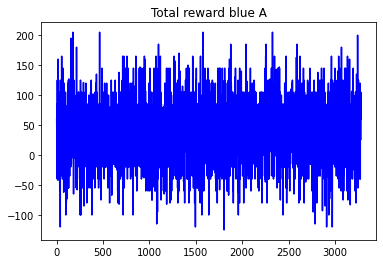

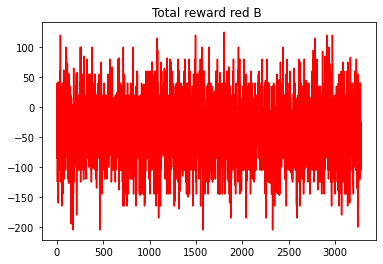

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import json
drive.mount('/content/drive')
import os
# os.chdir('/content/drive/MyDrive/1class 109下課程/人工智慧概論/hw_4') 
os.chdir('/content/drive/MyDrive/Colab Notebooks') 
os.listdir() #確認目錄內容
with open('a_v3.txt', newline='') as jsonfile:
    memA = json.load(jsonfile)
with open('b_v3.txt', newline='') as jsonfile:
    memB = json.load(jsonfile)
plt.plot(memA,'b')
plt.title("Total reward blue A")
plt.show()

plt.plot(memB,'r')
plt.title("Total reward red B ")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
# os.chdir('/content/drive/MyDrive/1class 109下課程/人工智慧概論/hw_4') 
os.chdir('/content/drive/MyDrive/Colab Notebooks') 
os.listdir() #確認目錄內容
torch.save(actor_a, "model/actor_A.pth")
torch.save(actor_a.state_dict(), PATH)
torch.save(actor_b, "model/actor_B.pth")
torch.save(v, "model/ValueNet.pth")

In [ ]:
drive.flush_and_unmount()